<a href="https://colab.research.google.com/github/rajaganesh1357/Time_Series_Repository/blob/main/Anomaly_detection_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Prophet

In [2]:
from prophet import Prophet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/rajaganesh1357/Dataset/main/energy_consumption.csv')
data = df.copy()
data.head()

,timeStamp,demand,precip,temp
0,01-01-2012 00:00,4937.5,0.0,46.13
1,01-01-2012 01:00,4752.1,0.0,45.89
2,01-01-2012 02:00,4542.6,0.0,45.04
3,01-01-2012 03:00,4357.7,0.0,45.03
4,01-01-2012 04:00,4275.5,0.0,42.61


In [45]:
data['timeStamp']=pd.to_datetime(data['timeStamp'],format='%d-%m-%Y %H:%M')
data=data.rename(columns={'timeStamp':'ds','demand':'y'})
data.head()

,ds,y,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [46]:
data.tail()

,ds,y,precip,temp
49119,2017-08-10 01:00:00,5714.258,0.0213,71.06
49120,2017-08-10 02:00:00,5497.025,0.0068,71.21
49121,2017-08-10 03:00:00,5360.583,0.0070,70.39
49122,2017-08-10 04:00:00,5333.775,0.0030,69.18
49123,2017-08-10 05:00:00,5534.683,0.0000,68.09


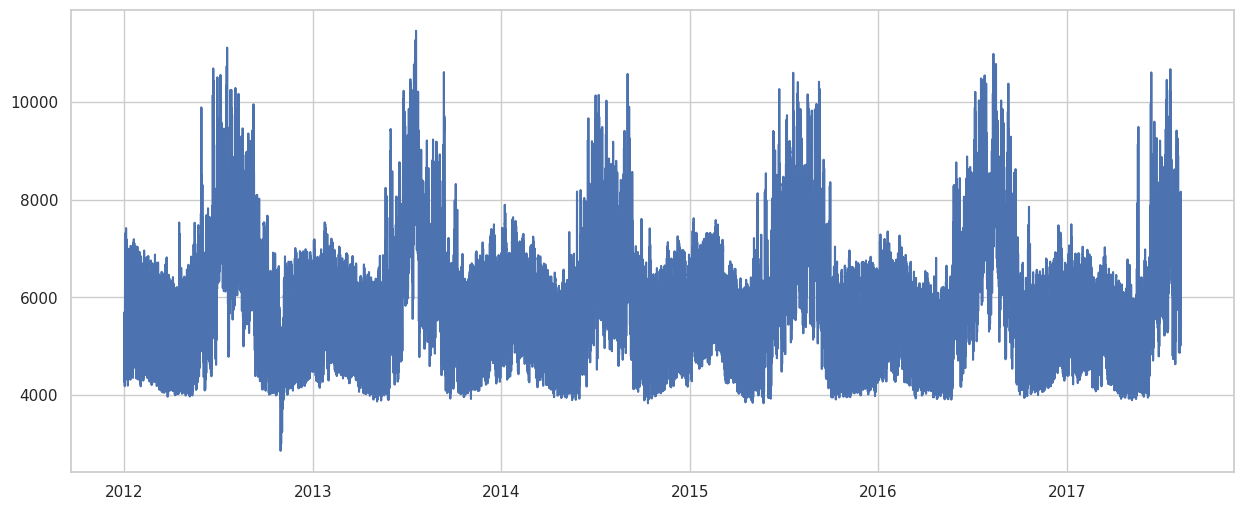

In [47]:
plt.figure(figsize=(15,6))
plt.plot(data['ds'],data['y'])
plt.show()

In [48]:
data['month'] = data['ds'].dt.month

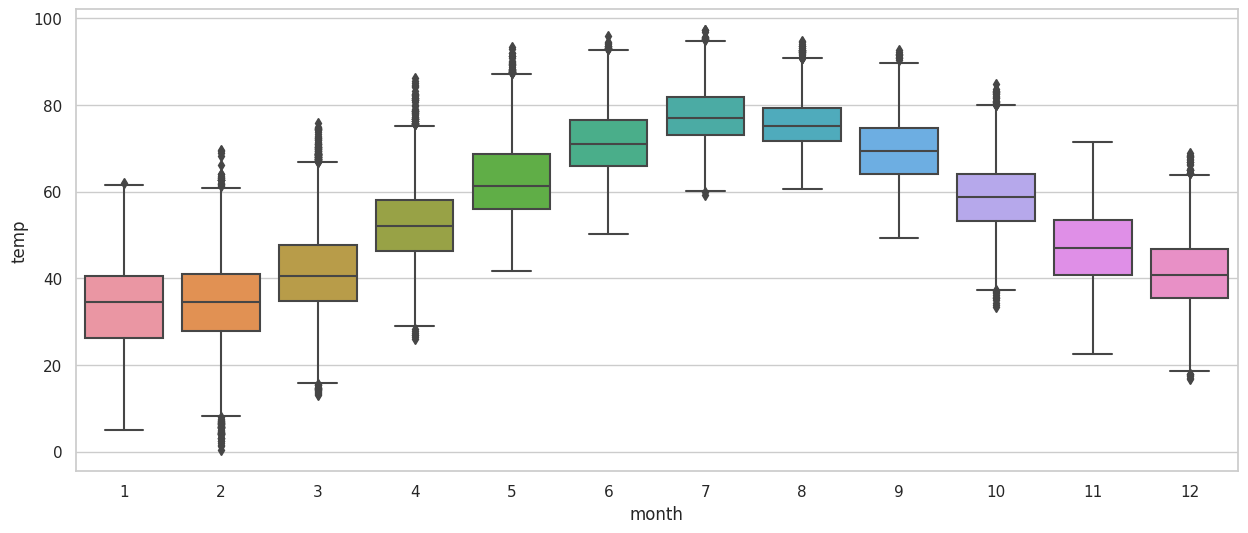

In [49]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.boxplot(x=data['month'], y=data['temp'])
plt.show()

In [50]:
def high_temp(temp):
  if temp > 70:
    return 1
  else:
    return 0

In [51]:
data['high_temp']=data['temp'].apply(high_temp)

In [52]:
model_hourly = Prophet(interval_width=0.95,yearly_seasonality = True)

In [53]:
data['month_bin']=pd.cut(data['month'],bins=4, labels=False)

In [54]:
model_hourly.add_regressor('high_temp',standardize=False)

In [55]:
model_hourly.add_regressor('month_bin',standardize=False)


In [56]:
train=data[(data['ds'] >= '2012-01-01') & (data['ds'] <= '2017-04-30')]
test=data[(data['ds'] > '2017-04-30')]

In [57]:
test.shape

(2449, 7)

In [58]:
model_hourly.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxlmz1zen/q3mefuce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxlmz1zen/qjvea4bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19216', 'data', 'file=/tmp/tmpxlmz1zen/q3mefuce.json', 'init=/tmp/tmpxlmz1zen/qjvea4bx.json', 'output', 'file=/tmp/tmpxlmz1zen/prophet_model4dbz054n/prophet_model-20230920122950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [77]:
forecast_index_hourly = model_hourly.make_future_dataframe(periods=2449,freq='H')

In [78]:
forecast_index_hourly['high_temp'] = data['high_temp']

In [79]:
forecast_index_hourly['month_bin'] = data['month_bin']

In [80]:
forecast_hourly = model_hourly.predict(forecast_index_hourly)
forecast_hourly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
49119,2017-08-09 21:00:00,8091.306915,6888.824852,9276.232037
49120,2017-08-09 22:00:00,7793.706820,6735.249070,8869.969236
49121,2017-08-09 23:00:00,7444.344166,6275.815300,8670.463033
49122,2017-08-10 00:00:00,6212.334512,5025.929660,7383.558982
49123,2017-08-10 01:00:00,5920.266795,4723.214959,7096.637160


In [81]:
model_comparison=pd.concat([data.set_index('ds')['y'],forecast_hourly.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)

In [ ]:
model_comparison

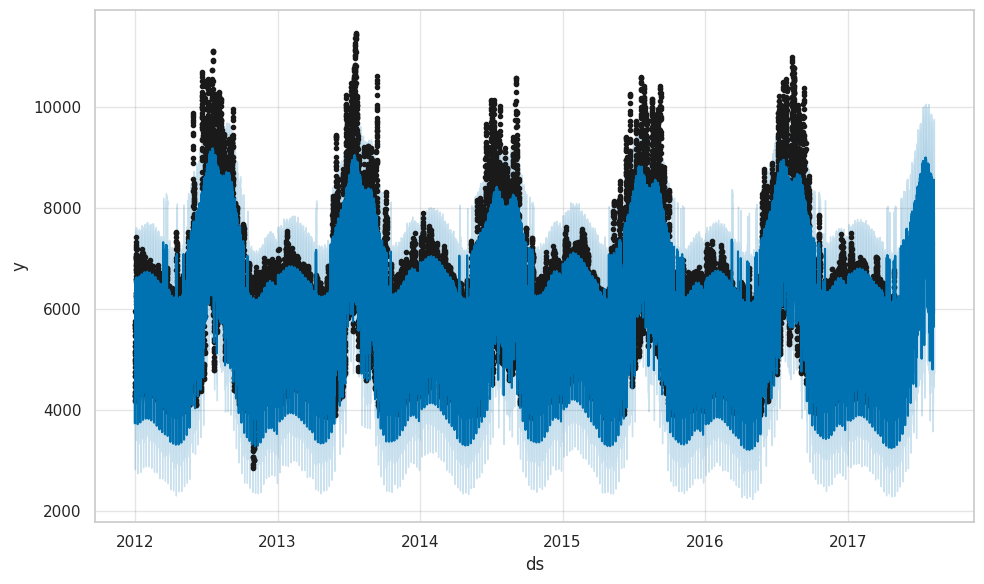

In [84]:
model_hourly.plot(forecast_hourly)
plt.show()

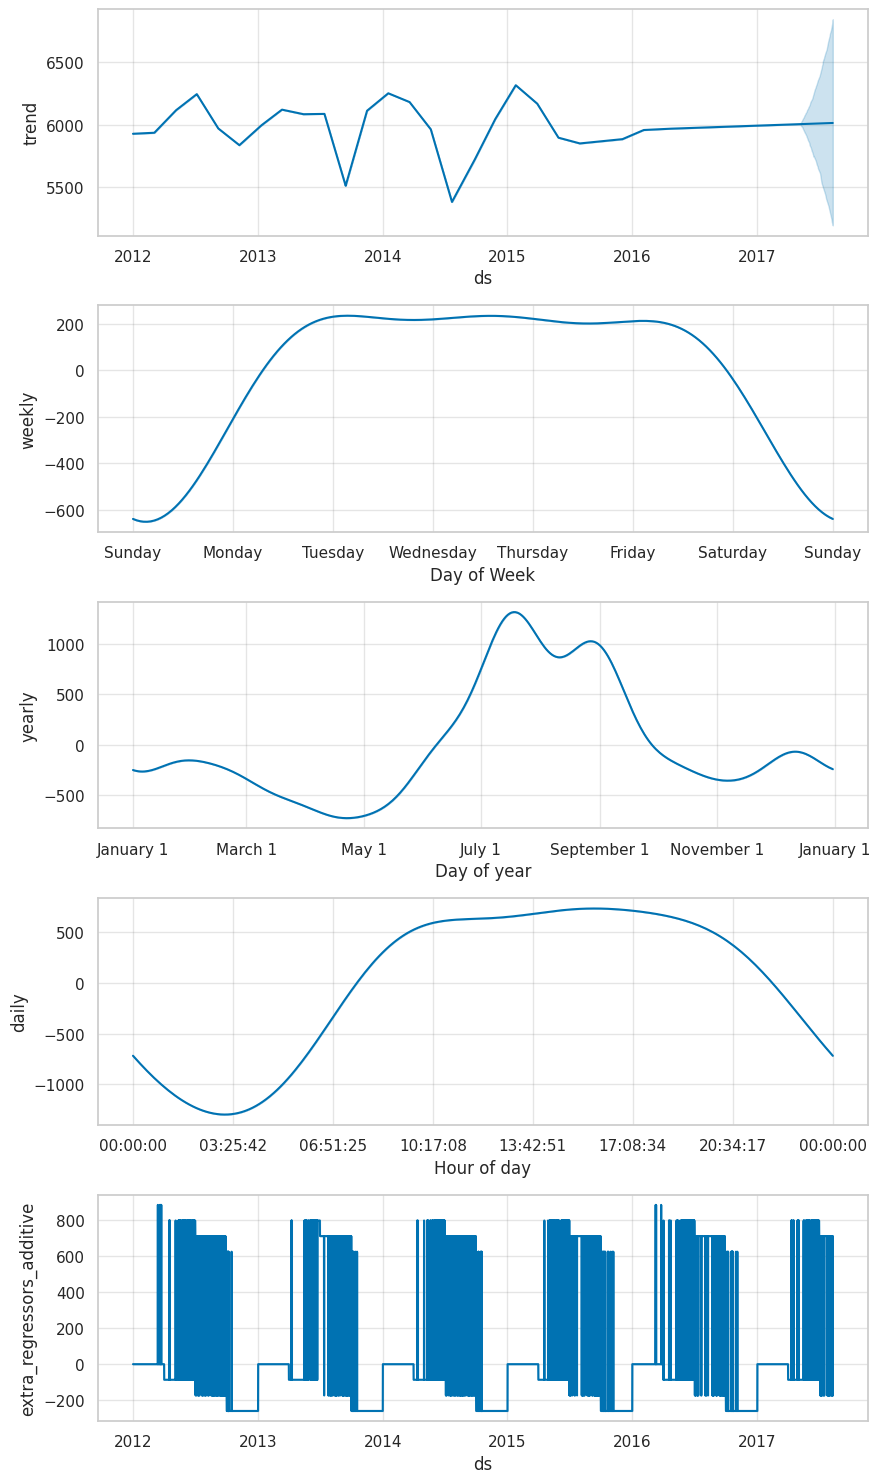

In [85]:
model_hourly.plot_components(forecast_hourly)
plt.show()

In [86]:
model_comparison['error'] = model_comparison['y'] - model_comparison['yhat']

In [87]:
model_comparison["uncertainty"] = model_comparison['yhat_upper'] - model_comparison['yhat_lower']

In [ ]:
model_comparison

In [92]:
model_comparison[model_comparison['error'].abs() >  1.3*model_comparison['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2013-07-19 11:00:00,11359.800,8866.667612,7950.752677,9776.718054,2493.132388,1825.965377
2013-07-19 13:00:00,11412.800,8880.574845,7979.394373,9755.989337,2532.225155,1776.594964
2013-07-19 14:00:00,11417.500,8905.057450,7997.476916,9753.095478,2512.442550,1755.618562
2013-07-19 15:00:00,11442.900,8924.228815,8016.932062,9891.728736,2518.671185,1874.796674
2013-07-19 16:00:00,11456.000,8918.597684,7937.445093,9824.214593,2537.402316,1886.769500
2013-07-19 17:00:00,11345.600,8885.239401,7956.274720,9839.792089,2460.360599,1883.517368
2013-09-11 13:00:00,10242.100,7750.358785,6837.802613,8728.475484,2491.741215,1890.672871
2013-09-11 14:00:00,10401.800,7784.455444,6763.588562,8738.176034,2617.344556,1974.587472
2013-09-11 15:00:00,10529.800,7814.427523,6822.656118,8731.062315,2715.372477,1908.406197


In [96]:
model_comparison['anomaly'] = model_comparison.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.3*x['uncertainty']) else 'No', axis=1)

In [97]:
import plotly.express as px

In [98]:
fig = px.scatter(model_comparison.reset_index(), x='ds', y='y', color='anomaly', title='Prophet_Stationary_Multivariate')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

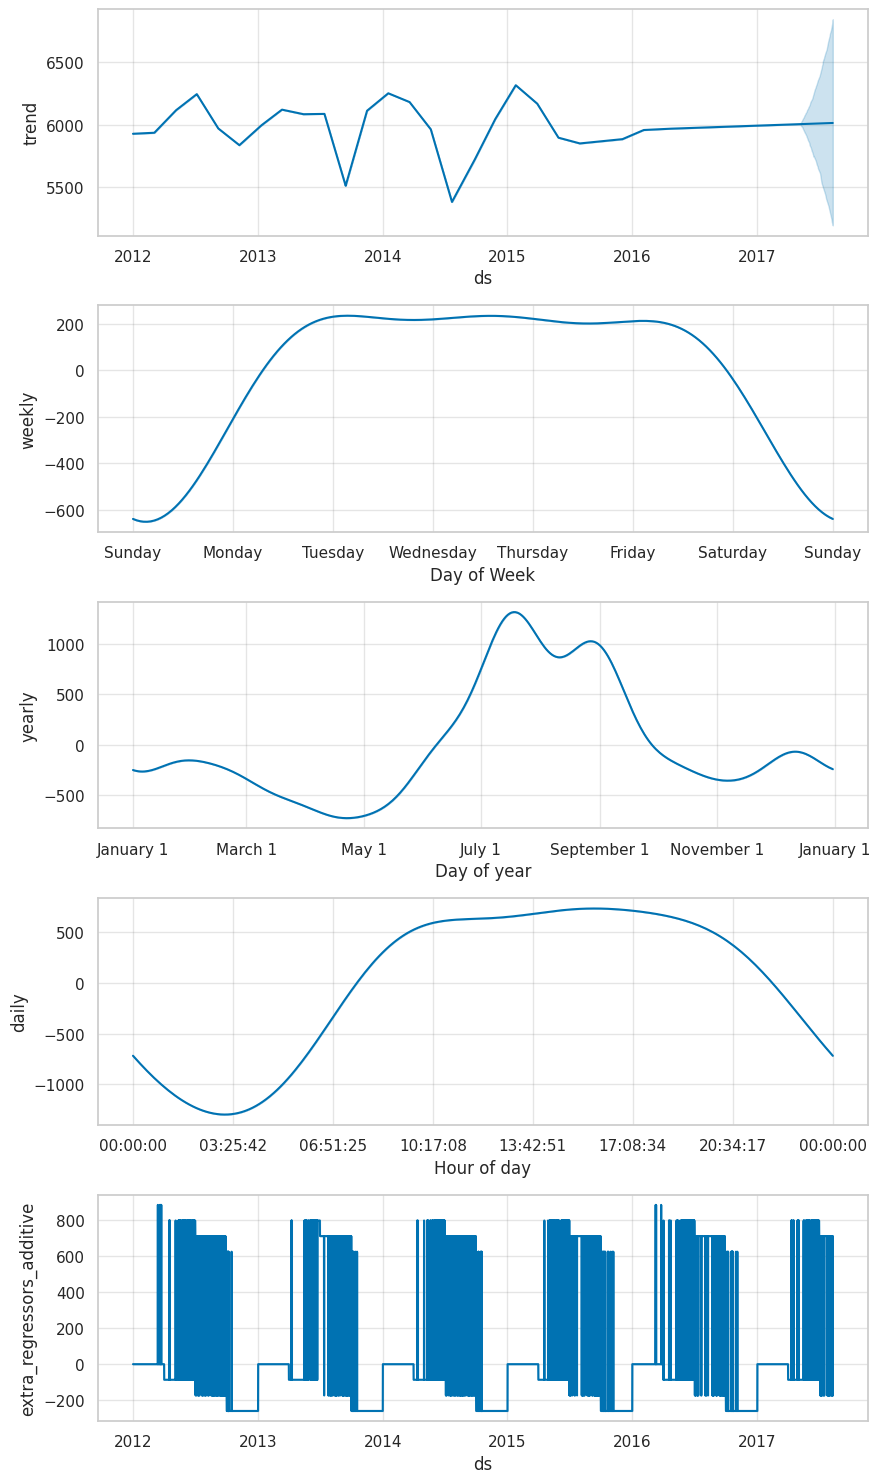

In [99]:
model_hourly.plot_components(forecast_hourly)
plt.show()